# Univariate Time Series Model for American River Riverflow Using TensorFlow
### David Lowe
### April 6, 2022

SUMMARY: The project aims to construct a time series prediction model and document the end-to-end steps using a template. The American River Riverflow dataset is a univariate time series situation where we attempt to forecast future outcomes based on past data points.

INTRODUCTION: The problem is to forecast the monthly river flow for American River at Fair Oaks, California. The dataset describes a time series of flow volume (in cms) over 55 years (1906-1960), and there are 660 observations. We used the first 80% of the observations for training and testing various models while holding back the remaining observations for validating the final model.

ANALYSIS: The baseline persistence model yielded an RMSE of 112.477. The MLP model processed the same test data with an RMSE of 88.34, which was better than the baseline model as expected. In an earlier ARIMA modeling experiment, the best ARIMA model with non-seasonal order of (1, 0, 0) and seasonal order of (1, 0, 1, 12) processed the validation data with an RMSE of 78.413.

CONCLUSION: For this dataset, the TensorFlow MLP model achieved an acceptable result, and we should consider using TensorFlow for further modeling.

Dataset Used: Monthly river flow in cms, American River at Fair Oaks, California from October 1906 through September 1960

Dataset ML Model: Time series forecast with numerical attribute

Dataset Reference: Rob Hyndman and Yangzhuoran Yang (2018). tsdl: Time Series Data Library. v0.1.0. https://pkg.yangzhuoranyang./tsdl/.

## Task 1 - Define Problem and Acquire Data

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


In [2]:
# Retrieve memory configuration information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [3]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Thu Mar 31 12:32:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.a) Load Libraries

In [4]:
# Create the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import random
import numpy as np
import tensorflow as tf
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn.metrics import mean_squared_error

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set various default modeling parameters
DEFAULT_LOSS = 'mean_squared_error'
DEFAULT_METRICS = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
MAX_EPOCHS = 20
BATCH_SIZE = 16
SLIDING_WINDOW = 5

In [7]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [8]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 1 - Define Problem and Acquire Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

In [9]:
# load the dataset and the necessary data structure
time_series = pd.read_csv('https://dainesanalytics.com/datasets/time-series-data-library/tsdl228.csv', index_col='idx', parse_dates=True)

# Load the dataset from the Federal Reserve Bank's FRED Database
# starting = datetime(1990, 1, 1)
# ending = datetime.now()
# fred_data = 'SMU06000007072251101'
# time_series = web.DataReader(fred_data, 'fred', starting, ending)
# time_series.rename(columns={fred_data: 'value'}, inplace=True)

# Sample code for subsetting the time-series data
# time_series = original_series['1986':'1990']

In [10]:
target_col = time_series.columns[0]
lower_bound = 'lower ' + target_col
upper_bound = 'upper ' + target_col
print('The target column of the time series is:', target_col)
print('The forecast boundary columns are:', lower_bound, '&', upper_bound)

The target column of the time series is: values
The forecast boundary columns are: lower values & upper values


In [11]:
time_series.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 660 entries, 1906-10-01 to 1961-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   values  660 non-null    float64
dtypes: float64(1)
memory usage: 10.3 KB


In [12]:
print(time_series.head())

              values
idx                 
1906-10-01    4.1626
1906-11-01    5.4935
1906-12-01    7.1925
1907-01-01  205.5237
1907-02-01  168.0322


In [13]:
print(time_series.tail())

             values
idx                
1961-05-01  53.8303
1961-06-01  81.8074
1961-07-01  95.3428
1961-08-01  67.0543
1961-09-01  34.9713


In [14]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 1 - Define Problem and Acquire Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2: Summarize and Visualize Data

In [15]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

In [16]:
# Summary statistics of time series
print(time_series.describe())

           values
count  660.000000
mean   106.186175
std    119.789848
min      0.447400
25%     15.453900
50%     54.694000
75%    167.671150
max    699.709400


### 2.b) Line Plot of the Time Series Data

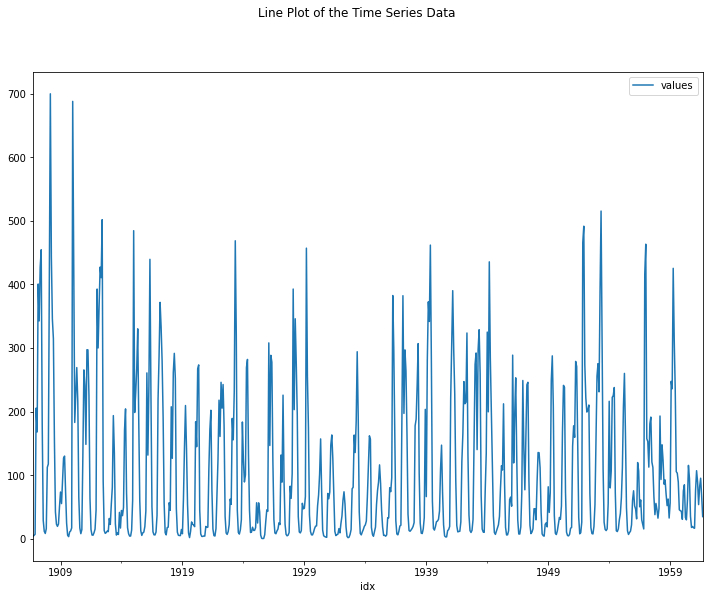

In [17]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Time Series Data')
time_series.plot(ax=ax)
plt.show()

### 2.c) Histogram and Density Plots of the Time Series Data

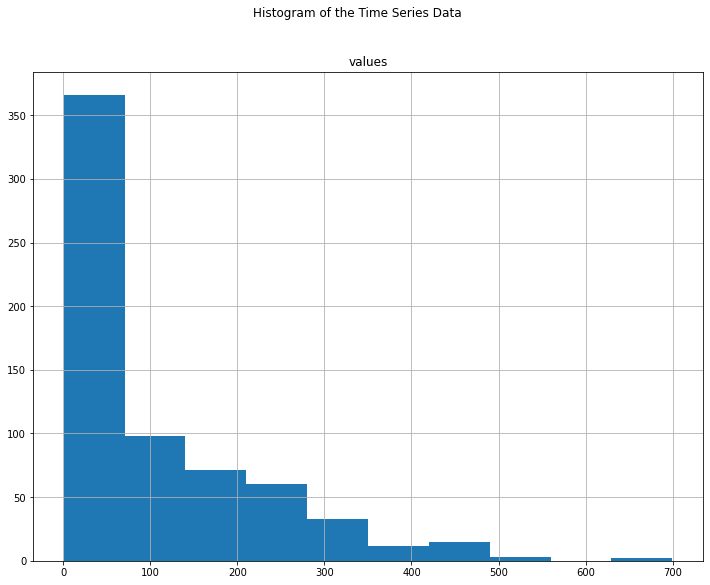

In [18]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Histogram of the Time Series Data')
time_series.hist(ax=ax)
plt.show()

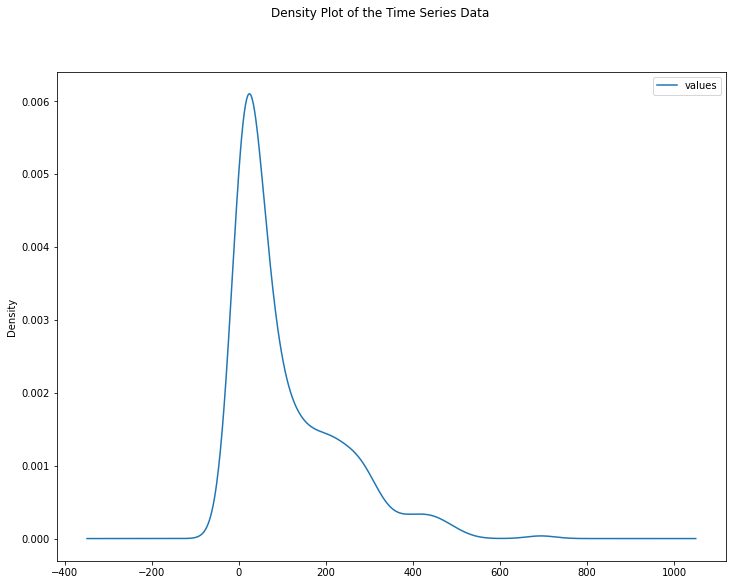

In [19]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
time_series.plot(kind='kde', ax=ax)
plt.show()

### 2.d) Box and Whisker Plots of the Time Series Data

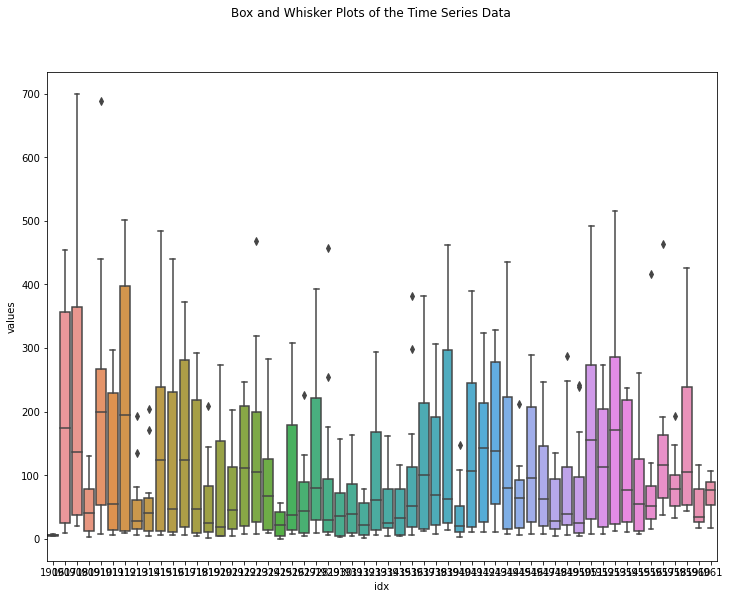

In [20]:
# boxplots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Box and Whisker Plots of the Time Series Data')
squeezed = time_series.squeeze()
sns.boxplot(x=squeezed.index.year, y=squeezed, ax=ax)
plt.show()

In [21]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3: Pre-Process Data

In [22]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 3 - Pre-Process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [23]:
# Resampling the time series into monthly average for the ease of modeling
# original_series = time_series
# resample = original_series.resample('M')
# time_series = resample.mean()
# time_series.head(10)

In [24]:
# Split the data into training and test sets
data = time_series.values
data = data.astype('float32')
n_test = 132
n_train = len(data) - n_test
train_ts, test_ts = data[0:n_train], data[n_train:]
print('Number of data points in the training set:', n_train)
print('Number of data points in the test set:', n_test)

Number of data points in the training set: 528
Number of data points in the test set: 132


In [25]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 3 - Pre-Process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4: Train and Tune Models

In [26]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set up the Common Helper Functions

In [27]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()

### 4.b) Simple Persistent Modeling as a Baseline

In [28]:
# fit a model
def model_fit(train, config):
    return None

In [29]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    values = list()
    for offset in config:
        values.append(history[-offset])
    return np.median(values)

In [30]:
# define config
config = [12, 24, 36]
# grid search
persistent_scores = repeat_evaluate(data, config, n_test)

 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477
 > 112.477


Persistence Model: 112.477 RMSE (+/- 0.000)


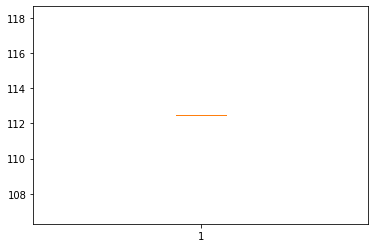

In [31]:
# summarize scores
summarize_scores('Persistence Model', persistent_scores)

### 4.c) MLP Modeling and Tuning

In [32]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [33]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    # prepare data
    x_input = np.array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [34]:
# define config
config = [24, 512, 100, 72]
# grid search
mlp_scores = repeat_evaluate(data, config, n_test)

 > 88.846
 > 89.751
 > 91.566
 > 89.824
 > 87.165
 > 86.053
 > 88.078
 > 86.242
 > 86.188
 > 87.919
 > 87.662
 > 86.768
 > 87.349
 > 86.955
 > 87.975
 > 87.801
 > 89.302
 > 85.621
 > 88.647
 > 88.703
 > 88.953
 > 89.020
 > 89.109
 > 86.355
 > 87.017
 > 87.633
 > 91.648
 > 91.953
 > 90.328
 > 89.773


MLP Model: 88.340 RMSE (+/- 1.665)


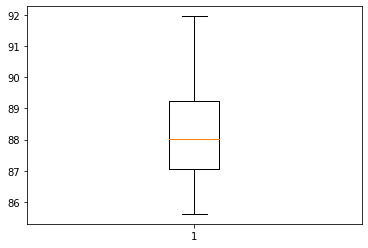

In [35]:
# summarize scores
summarize_scores('MLP Model', mlp_scores)

### 4.d) CNN Modeling and Tuning

In [36]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
    model.add(tf.keras.layers.Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss=DEFAULT_LOSS, optimizer=DEFAULT_OPTIMIZER)
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [37]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _ = config
    # prepare data
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [38]:
# define config
config = [36, 256, 3, 100, 72]
# grid search
cnn_scores = repeat_evaluate(data, config, n_test)

 > 101.963
 > 112.183
 > 109.846
 > 107.454
 > 115.201
 > 106.558
 > 109.724
 > 109.770
 > 111.903
 > 109.990
 > 108.526
 > 112.221
 > 102.865
 > 110.931
 > 108.713
 > 112.135
 > 109.355
 > 105.968
 > 106.331
 > 109.510
 > 105.406
 > 107.494
 > 106.595
 > 112.771
 > 108.783
 > 104.572
 > 112.895
 > 107.821
 > 107.370
 > 108.289


CNN Model: 108.772 RMSE (+/- 2.996)


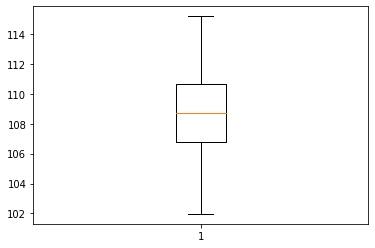

In [39]:
# summarize scores
summarize_scores('CNN Model', cnn_scores)

### 4.e) LSTM Modeling and Tuning

In [40]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(tf.keras.layers.Dense(n_nodes, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss=DEFAULT_LOSS, optimizer=DEFAULT_OPTIMIZER)
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [41]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

In [42]:
# define config
config = [36, 256, 100, 72, 12]
# grid search
lstm_scores = repeat_evaluate(data, config, n_test)

 > 137.953
 > 155.255
 > 154.836
 > 164.454
 > 161.117
 > 170.694
 > 152.669
 > 138.462
 > 136.636
 > 176.316
 > 162.720
 > 133.133
 > 171.428
 > 331.869
 > 899.391
 > 140.533
 > 139.903
 > 234.175
 > 143.376
 > 142.763
 > 259.877
 > 154.057
 > 155.995
 > 331.302
 > 134.897
 > 990.861
 > 295.486
 > 202.397
 > 156.776
 > 144.383


LSTM Model: 229.124 RMSE (+/- 199.445)


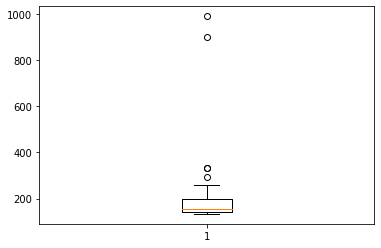

In [43]:
# summarize scores
summarize_scores('LSTM Model', lstm_scores)

### 4.f) CNN-LSTM Modeling and Tuning

In [44]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None,n_steps,1))))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2)))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
    model.add(tf.keras.layers.LSTM(n_nodes, activation='relu'))
    model.add(tf.keras.layers.Dense(n_nodes, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss=DEFAULT_LOSS, optimizer=DEFAULT_OPTIMIZER)
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [45]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [46]:
# define config
config = [3, 12, 128, 3, 100, 200, 72]
# grid search
cnnlstm_scores = repeat_evaluate(data, config, n_test)

 > 113.420
 > 126.940
 > 107.785
 > 104.130
 > 121.708
 > 103.041
 > 113.668
 > 110.487
 > 101.677
 > 105.364
 > 111.941
 > 109.124
 > 112.508
 > 105.770
 > 114.665
 > 112.782
 > 109.338
 > 112.127
 > 107.568
 > 106.074
 > 104.971
 > 123.385
 > 102.723
 > 118.294
 > 113.693
 > 102.399
 > 110.690
 > 112.683
 > 105.431
 > 109.029


CNN-LSTM Model: 110.447 RMSE (+/- 6.147)


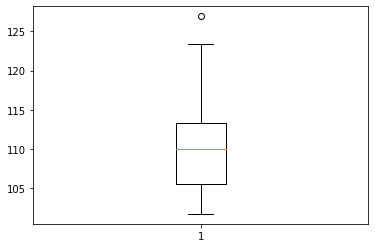

In [47]:
# summarize scores
summarize_scores('CNN-LSTM Model', cnnlstm_scores)

### 4.g) ConvLSTM Modeling and Tuning

In [48]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu', input_shape=(n_seq, 1, n_steps, 1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_nodes, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss=DEFAULT_LOSS, optimizer=DEFAULT_OPTIMIZER)
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [49]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [50]:
# define config
config = [3, 12, 256, 3, 200, 200, 72]
# grid search
convlstm_scores = repeat_evaluate(data, config, n_test)

 > 117.551
 > 102.432
 > 95.604
 > 102.114
 > 102.375
 > 99.622
 > 106.162
 > 103.278
 > 100.991
 > 97.704
 > 104.906
 > 107.267
 > 107.059
 > 107.205
 > 101.540
 > 103.381
 > 108.033
 > 104.607
 > 103.948
 > 99.158
 > 104.719
 > 105.107
 > 101.786
 > 108.246
 > 94.553
 > 105.112
 > 105.439
 > 105.529
 > 108.000
 > 96.704


ConvLSTM Model: 103.671 RMSE (+/- 4.468)


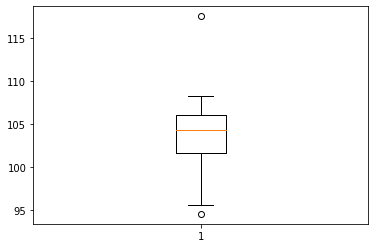

In [51]:
# summarize scores
summarize_scores('ConvLSTM Model', convlstm_scores)

### 4.g) Models Comparison

In [52]:
# Set up Arrays for Score Comparison
train_models = []
train_results = []

In [53]:
train_models.append('Baseline')
train_results.append(persistent_scores)
train_models.append('MLP')
train_results.append(mlp_scores)
train_models.append('CNN')
train_results.append(cnn_scores)
train_models.append('LSTM')
train_results.append(lstm_scores)
train_models.append('CNN-LSTM')
train_results.append(cnnlstm_scores)
train_models.append('ConvLSTM')
train_results.append(convlstm_scores)

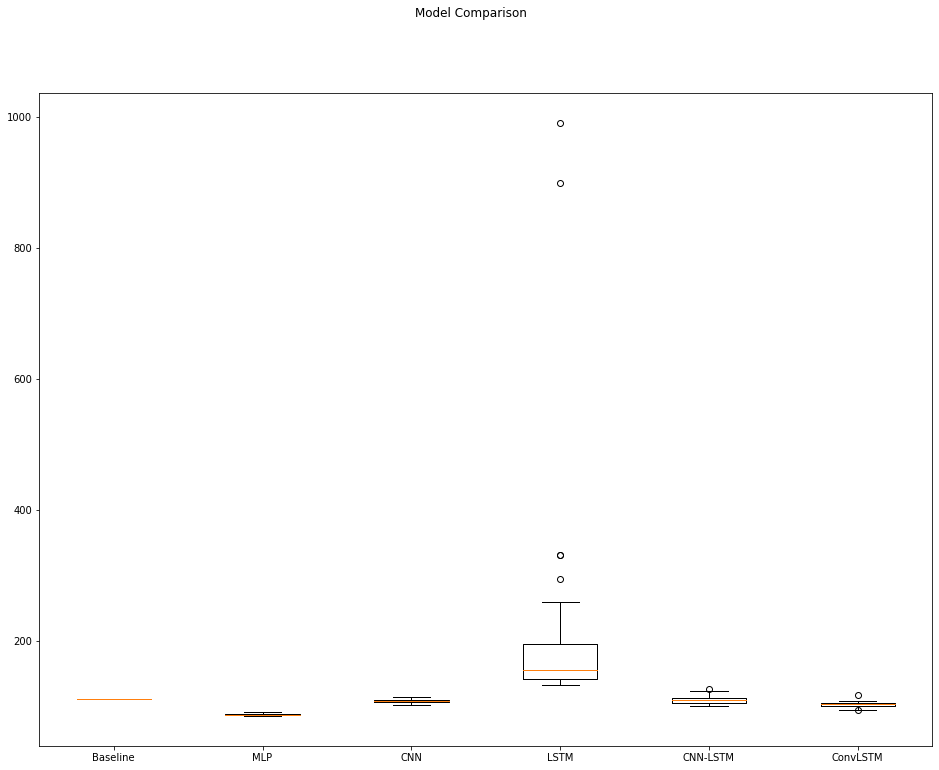

In [54]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_models)
plt.show()

In [55]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize Model and Make Predictions

In [56]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [57]:
# Code Segment Under Construction

In [58]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [59]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:50:35.789546
